In [1]:
# !pip uninstall tensorflow -y
# !pip install tensorflow==2.10.1  # Versión compatible con CUDA 11.2

In [2]:
# !pip install --upgrade pip
# !pip install tensorflow==2.13.1 numpy==1.23.5 albumentations==1.2.1 typing-extensions==4.5.0 opencv-python-headless==4.5.5.64 scikit-image==0.19.3

In [3]:
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys
import pandas as pd
import sklearn as sk
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(tf.config.list_physical_devices('GPU'))
print("GPU is", "available" if gpu else "NOT AVAILABLE")

2025-07-30 04:04:46.741349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-30 04:04:47.224540: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 04:04:47.432896: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 04:04:49.289365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Tensor Flow Version: 2.10.1
Keras Version: 2.10.0

Python 3.8.12 (default, Mar 27 2025, 14:46:10) 
[GCC 7.5.0]
Pandas 1.2.5
Scikit-Learn 1.3.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


2025-07-30 04:04:52.949970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-30 04:04:53.023022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-30 04:04:53.024100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# SEMILLA
tf.random.set_seed(42)

In [5]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     # Asignar 8GB a cada modelo (24GB total / 3 modelos)
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=10000)]  # 8GB en MB
#     )
#     print("GPU limitada a 10GB para este notebook.")

# Implementación personalizada de ruido sal y pimienta
class SaltAndPepperNoise(ImageOnlyTransform):
    def __init__(self, salt_prob=0.01, pepper_prob=0.01, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def apply(self, img, **params):
        noise = np.random.rand(*img.shape[:2])
        img = img.copy()
        img[noise < self.salt_prob] = [255, 255, 255]  # Sal
        img[(noise >= self.salt_prob) & (noise < (self.salt_prob + self.pepper_prob))] = [0, 0, 0]  # Pimienta
        return img

    def get_transform_init_args_names(self):
        return ("salt_prob", "pepper_prob")

# Transformaciones para aumento de datos en entrenamiento
transform_entrenamiento = A.Compose([
    A.HorizontalFlip(p=0.5),
    
    # ⚠️ Comentamos transformaciones que pueden alterar el color drásticamente
    A.GaussNoise(var_limit=(5.0, 10.0), mean=0, p=0.4),
    # SaltAndPepperNoise(salt_prob=0.01, pepper_prob=0.01, p=0.3),
    
    A.RandomBrightnessContrast(
        brightness_limit=(-0.15, 0),  # Limitamos el cambio de brillo
        contrast_limit=0.0,
        p=0.3
    ),
    
    A.CoarseDropout(
        max_holes=1,
        max_height=int(forma_entrada[0] * 0.1),
        max_width=int(forma_entrada[1] * 0.1),
        min_holes=1,
        min_height=int(forma_entrada[0] * 0.05),
        min_width=int(forma_entrada[1] * 0.05),
        fill_value=0,
        p=0.3
    )
])

# Función de aumento corregida
def augment_image_alb(image):
    """
    Aplica transformaciones de Albumentations a una imagen.
    """
    # Si la imagen tiene 4 canales (RGBA), convertir a RGB
    if image.shape[2] == 4:
        image = image[:, :, :3]

    # Si ya viene normalizada [0, 1], desnormalizar a [0, 255]
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)

    # Asegurar que tenga 3 canales
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Aplicar transformaciones
    augmented = transform_entrenamiento(image=image)["image"]

    # Convertir a float32 y normalizar a [0, 1]
    return augmented.astype(np.float32) / 255.0

In [6]:

import albumentations as A
import cv2
import numpy as np
from albumentations.core.transforms_interface import ImageOnlyTransform
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Parámetros
forma_entrada = (224, 224, 3)
tamaño_lote = 64 # si es con la data base, usar 32
épocas = 60
initial_learning_rate = 1e-3

preprocess_fn = tf.keras.applications.mobilenet_v2.preprocess_input

# Rutas
ruta_entrenamiento = './datasets/2D/data_augmentation/color_2/train'
ruta_validacion = './datasets/2D/data_augmentation/color_2/validation'
ruta_test = './datasets/2D/data_augmentation/color_2/test'
# Generadores
datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_fn,
    rescale=1./255
)
datagen_valid = ImageDataGenerator(
    # preprocessing_function=preprocess_fn,
    rescale=1./255
) # ANTES APLIQUE RESCALE
datagen_test = ImageDataGenerator(
    # preprocessing_function=preprocess_fn,
    rescale=1./255
)

generador_entrenamiento = datagen.flow_from_directory(
    ruta_entrenamiento,
    target_size=forma_entrada[:2],
    batch_size=tamaño_lote,
    shuffle=True,
    class_mode='categorical'
)

generador_validacion = datagen_valid.flow_from_directory(
    ruta_validacion,
    target_size=forma_entrada[:2],
    batch_size=tamaño_lote,
    shuffle=False,
    class_mode='categorical'
)

generador_test = datagen_test.flow_from_directory(
    ruta_test,
    target_size=forma_entrada[:2],
    batch_size=tamaño_lote,
    shuffle=False,
    class_mode='categorical'
)


Found 40000 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.


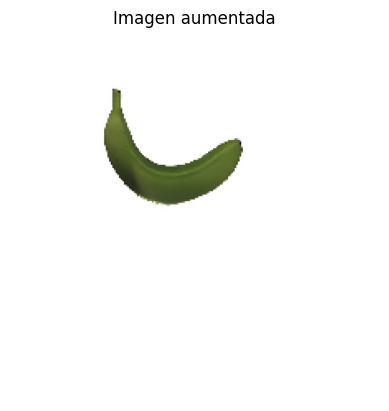

In [8]:
import matplotlib.pyplot as plt

# Supón que `x, y = generador_entrenamiento.next()`
x_batch, y_batch = next(generador_entrenamiento)

plt.imshow(x_batch[0])
plt.axis('off')
plt.title("Imagen aumentada")
plt.show()


Imágenes de entrenamiento (con aumentación):


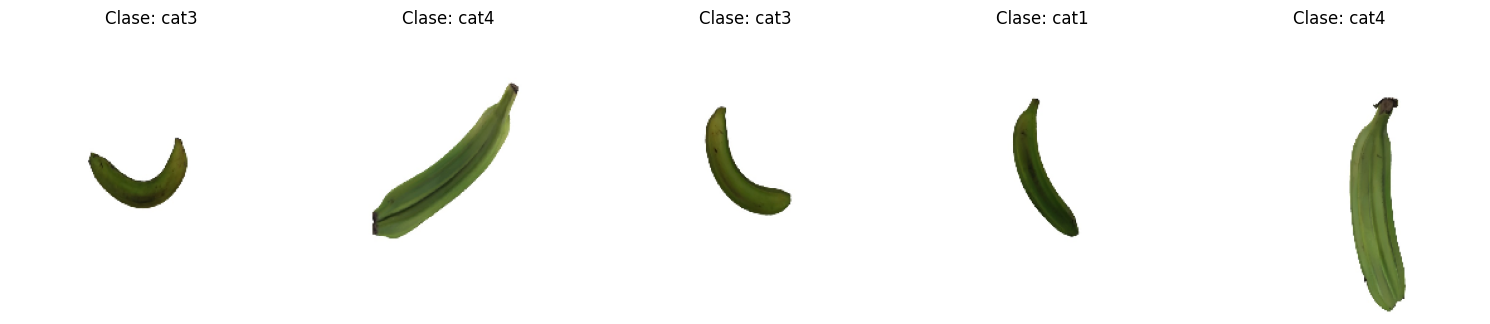


Imágenes de validación (con aumentación):


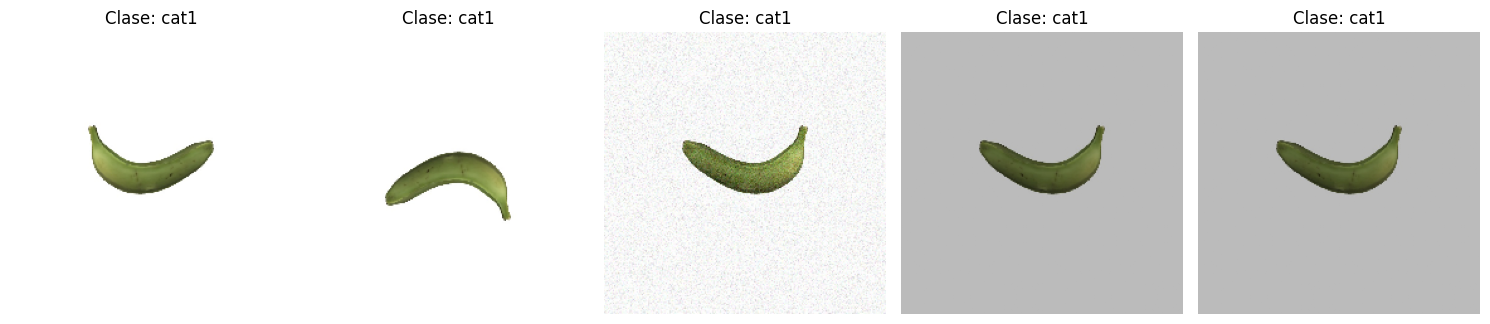


Imágenes de testeo (sin aumentación):


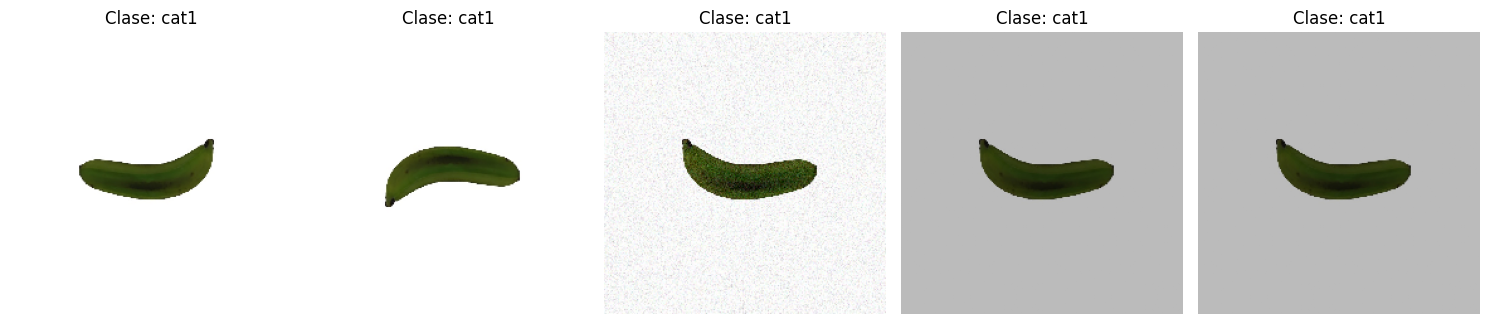

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def mostrar_imagenes(generador, num_imagenes=5):
    """
    Muestra imágenes y sus etiquetas de un generador de Keras.
    
    Args:
        generador: Objeto ImageDataGenerator (ej: generador_entrenamiento)
        num_imagenes: Número de imágenes a mostrar (por defecto 5)
    """
    # Obtener un batch de imágenes
    batch = next(generador)
    images, labels = batch[0], batch[1]
    
    # Crear figura
    plt.figure(figsize=(15, 5))
    
    for i in range(min(num_imagenes, len(images))):
        # Mostrar imagen
        plt.subplot(1, num_imagenes, i+1)
        plt.imshow(images[i])
        
        # Obtener etiqueta (asumiendo one-hot encoding)
        class_idx = np.argmax(labels[i])
        class_name = list(generador.class_indices.keys())[class_idx]
        
        plt.title(f"Clase: {class_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar imágenes de entrenamiento (con aumentación)
print("Imágenes de entrenamiento (con aumentación):")
mostrar_imagenes(generador_entrenamiento)

# Mostrar imágenes de validación (sin aumentación)
print("\nImágenes de validación (con aumentación):")
mostrar_imagenes(generador_validacion)


print("\nImágenes de testeo (sin aumentación):")
mostrar_imagenes(generador_test)

In [10]:
steps = len(generador_entrenamiento.filepaths) // generador_entrenamiento.batch_size

In [11]:
##### AÑADIR LR DECAY FACTOR #####
import tensorflow as tf
# learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=30*steps,  # Decaimiento más frecuente
#     decay_rate=0.9,  # Decaimiento más fuerte
#     staircase=True)

learning_rate=initial_learning_rate

# # #### USAR PESOS YA GUARDADOS
latest = "./models/MobilNet2/siamese_model_mobilnet_apple_data_REF.h5"
base_model = tf.keras.models.load_model(latest, compile=False)
base_model.summary

# Extraer el componente MobileNetV2 del modelo siamesa
mobilenet_layer = base_model.get_layer('mobilenetv2_1.00_224')  # Nombre exacto de la capa en tu modelo
mobilenet_layer.trainable = False  # Congelar pesos

entrada = layers.Input(shape=forma_entrada)
x = mobilenet_layer(entrada)  # Usar la VGG16 cargada
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.65)(x) # 0.7
salida = layers.Dense(4, activation='softmax')(x)

# 3. Compilar
modelo = Model(inputs=entrada, outputs=salida)
optimizador = tf.keras.optimizers.Adam(learning_rate=learning_rate)
modelo.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizador, 
    metrics=['accuracy']
)

modelo.summary()

In [12]:
# # Modelo base usando MobileNetV2
def model_init(learning_rate, dropout_rate, l2_reg):
    modelo_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=forma_entrada)
    # modelo_base = MobileNetV2(weights=None, include_top=False, input_shape=forma_entrada)
    for capa in modelo_base.layers:
        capa.trainable = False
    # # Definición del modelo de un solo input (RGB)
    entrada = layers.Input(shape=forma_entrada)
    x = modelo_base(entrada)
    x = layers.Flatten()(x)
    # x = BatchNormalization()(x)
    x = layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg)
    )(x)
    x = layers.Dropout(dropout_rate)(x)
    salida = layers.Dense(4, activation='softmax')(x)
    
    modelo = Model(inputs=entrada, outputs=salida)
    optimizador = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    modelo.compile(loss='categorical_crossentropy', optimizer=optimizador, metrics=['accuracy'])
    return modelo

In [13]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Definir función objetivo a optimizar
def optimize_model(lr, dropout_rate, l2_reg):
    # Convertir parámetros
    lr = 10**lr  # Usar escala logarítmica
    l2_reg = 10**l2_reg
    
    # Construir modelo con hiperparámetros actuales
    modelo = model_init(
        learning_rate=lr,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg
    )
    
    # Entrenamiento reducido para evaluación rápida
    history = modelo.fit(
        generador_entrenamiento,
        # steps_per_epoch=train_samples // tamaño_lote,  # Subconjunto para optimización
        validation_data=generador_validacion,
        # validation_steps=val_samples // tamaño_lote,
        epochs=3,
        verbose=1
    )
    
    # Retornar el mejor valor de val_accuracy
    return np.max(history.history['val_accuracy'])

# 2. Definir espacio de búsqueda
pbounds = {
    'lr': (-5, -3),       # 10^-5 a 10^-3
    'dropout_rate': (0.6, 0.9),
    'l2_reg': (-5, -3),   # 10^-5 a 10^-2
}

# 3. Crear optimizador bayesiano
optimizer = BayesianOptimization(
    f=optimize_model,
    pbounds=pbounds,
    random_state=42,
    verbose=1
)

# 4. Ejecutar optimización
optimizer.maximize(
    init_points=2,  # Exploración inicial aleatoria
    n_iter=15,      # Iteraciones bayesianas
)

|   iter    |  target   | dropou... |  l2_reg   |    lr     |
-------------------------------------------------------------


2025-07-30 04:05:03.474468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-30 04:05:03.480653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-30 04:05:03.481326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-30 04:05:03.481936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may h

Epoch 1/3


2025-07-30 04:05:14.945436: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-07-30 04:05:17.695020: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-07-30 04:05:17.695128: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-07-30 04:05:17.695268: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-07-30 04:05:19.743626: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 690s 1s/step - loss: 0.6014 - accuracy: 0.8311 - val_loss: 0.7067 - val_accuracy: 0.7788
Epoch 2/3
625/625 [==============================] - 595s 952ms/step - loss: 0.3884 - accuracy: 0.8857 - val_loss: 0.5369 - val_accuracy: 0.8050
Epoch 3/3
625/625 [==============================] - 656s 1s/step - loss: 0.3242 - accuracy: 0.9068 - val_loss: 0.4826 - val_accuracy: 0.8242
Epoch 1/3
625/625 [==============================] - 606s 966ms/step - loss: 0.4085 - accuracy: 0.8407 - val_loss: 0.4061 - val_accuracy: 0.7832
Epoch 2/3
625/625 [==============================] - 575s 920ms/step - loss: 0.1841 - accuracy: 0.9303 - val_loss: 0.4371 - val_accuracy: 0.7932
Epoch 3/3
625/625 [==============================] - 562s 898ms/step - loss: 0.1296 - accuracy: 0.9527 - val_loss: 0.4421 - val_accuracy: 0.8136
Epoch 1/3
625/625 [==============================] - 568s 905ms/step - loss: 0.7321 - accuracy: 0.7688 - val_loss: 0.5433 - val_accuracy: 0.7934
E

In [14]:
# Obtener mejores parámetros
best_params = optimizer.max['params']

# Construir modelo final con mejores parámetros
modelo = model_init(
    learning_rate=10**best_params['lr'],
    dropout_rate=best_params['dropout_rate'],
    l2_reg=10**best_params['l2_reg']
)

In [15]:
optimizer.max['params']

{'dropout_rate': 0.9, 'l2_reg': -3.1027565591858237, 'lr': -3.636837393569275}

### Batch actualizado

In [16]:
# Configuración de callbacks
import os
path_models = './models/pruebas/MobilNet2_RGB_bayesian_batchdef/'
os.makedirs(path_models, exist_ok=True)
arch = 'MOBILNET_SINGLE_INPUT'

In [17]:
# Ruta donde se guardará el archivo (ej: 'C:/Users/tu_usuario/proyecto/resultados/hiperparametros.txt')
ruta_archivo = path_models + "hiperparametros.txt"  # ¡Cambia esto!

# Asegurarse de que la carpeta exista (si no, la crea)
os.makedirs(os.path.dirname(ruta_archivo), exist_ok=True)

# Guardar en formato legible (clave = valor)
with open(ruta_archivo, "w") as f:
    for key, value in best_params.items():
        f.write(f"{key} = {value}\n")

print(f"¡Hiperparámetros guardados en: {ruta_archivo}!")

¡Hiperparámetros guardados en: ./models/pruebas/MobilNet2_RGB_bayesian_batchdef/hiperparametros.txt!


In [18]:
checkpoint = ModelCheckpoint(
    path_models + "model_single_input_silhouette_0_0.h5",
    monitor='val_loss', # <-- Guarda el mejor modelo basado en val_loss (más estable que val_accuracy)
    verbose=1,
    save_best_only=True, # guarda cuando haya mejoras
    save_weights_only=True,
    mode='min', #estaba en auto
    period=10  # Guarda pesos cada 10 épocas
)

early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001, 
    patience=10,  # <-- Detén el entrenamiento cuando val_accuracy no mejore en 10 épocas
    verbose=1,
    restore_best_weights=True,
    mode='max'
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitorear pérdida de validación
    mode='min',         # Reducir LR cuando val_loss deje de disminuir
    factor=0.5,         # Reducción moderada del LR
    patience=3,        # Esperar 5 épocas sin mejora
    verbose=1,
    min_lr=1e-6         # LR mínimo permitido+
)


# from tensorflow.keras.callbacks import ReduceLROnPlateau

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,  # Reducir LR a la mitad
#     patience=10,  # Esperar 10 épocas sin mejora
#     min_lr=1e-6,  # LR mínimo
#     verbose=1
# )

# Añadir a los callbacks
callbacks = [checkpoint, reduce_lr, early]  # <-- Añadido

In [19]:
generador_entrenamiento.samples

40000

In [20]:
# Entrenamiento
historia = modelo.fit(
    generador_entrenamiento,
    #steps_per_epoch=generador_entrenamiento.samples // tamaño_lote,
    epochs=épocas,
    validation_data=generador_validacion,
    #validation_steps=generador_validacion.samples // tamaño_lote,
    callbacks=callbacks,
    # class_weight=class_weights  # <-- Añadir esto
)

modelo.save(path_models + arch + '/model_single_input_silhouette_0_0.h5')

Epoch 1/60
625/625 [==============================] - 597s 952ms/step - loss: 1.1411 - accuracy: 0.5445 - val_loss: 0.5639 - val_accuracy: 0.8840 - lr: 2.3076e-04
Epoch 2/60
625/625 [==============================] - 584s 934ms/step - loss: 0.9394 - accuracy: 0.5706 - val_loss: 0.5182 - val_accuracy: 0.8644 - lr: 2.3076e-04
Epoch 3/60
625/625 [==============================] - 583s 932ms/step - loss: 0.8752 - accuracy: 0.5863 - val_loss: 0.4746 - val_accuracy: 0.8618 - lr: 2.3076e-04
Epoch 4/60
625/625 [==============================] - 579s 926ms/step - loss: 0.8342 - accuracy: 0.6011 - val_loss: 0.4386 - val_accuracy: 0.8698 - lr: 2.3076e-04
Epoch 5/60
625/625 [==============================] - 562s 900ms/step - loss: 0.8207 - accuracy: 0.6079 - val_loss: 0.4694 - val_accuracy: 0.8536 - lr: 2.3076e-04
Epoch 6/60
625/625 [==============================] - 564s 902ms/step - loss: 0.7981 - accuracy: 0.6165 - val_loss: 0.4346 - val_accuracy: 0.8420 - lr: 2.3076e-04
Epoch 7/60
625/625 [==

Learning rate actual: 0.00023076110315073696


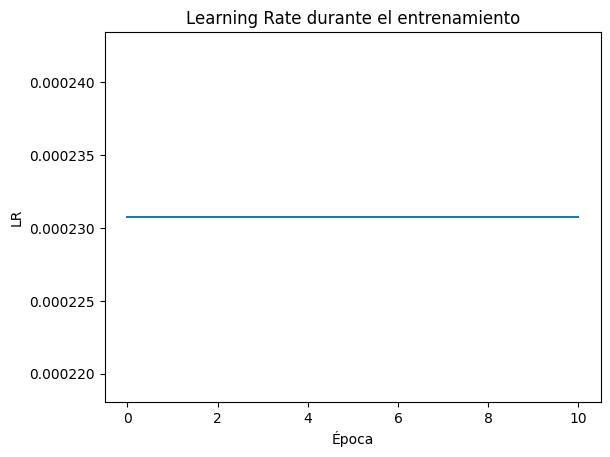

In [21]:
current_lr = modelo.optimizer.lr.numpy()
print(f"Learning rate actual: {current_lr}")

# Graficar el learning rate a lo largo de las épocas
plt.plot(historia.history['lr'])
plt.title('Learning Rate durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('LR')
plt.savefig(path_models + "MobileNetV2_silhouette_0_0_lr_plot.png")  # Guarda el gráfico en accuracy_plot.png
plt.show()

In [22]:
modelo.save(path_models + arch + '/model_single_input_silhouette_0_0.h5') 

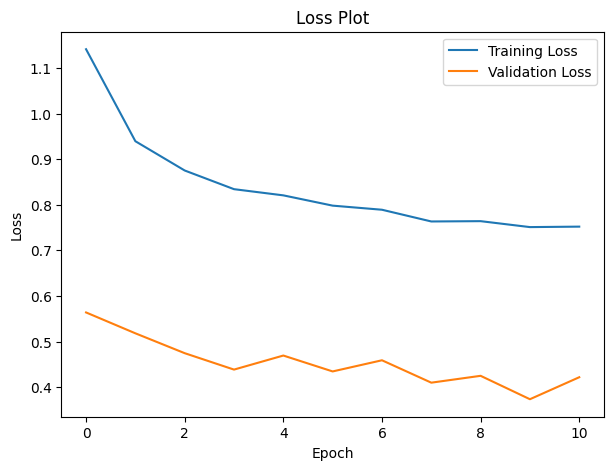

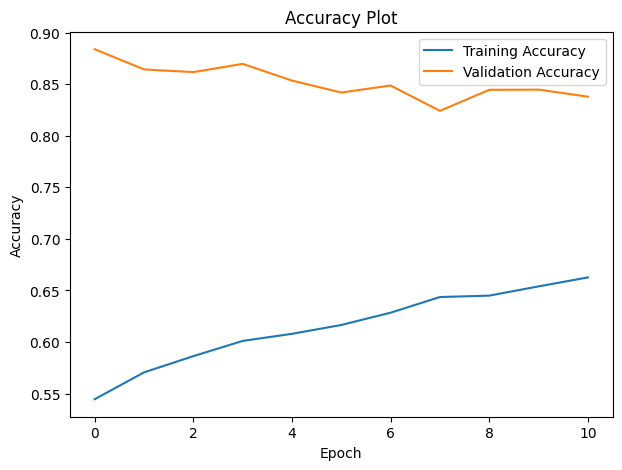

In [23]:
# Gráfico de Pérdida
plt.figure(figsize=(7,5))
plt.plot(historia.history['loss'], label='Training Loss')
plt.plot(historia.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path_models + "MobileNetV2_silhouette_0_0_loss_plot.png")  # Guarda el gráfico en loss_plot.png
plt.show()

# Gráfico de Precisión
plt.figure(figsize=(7,5))
plt.plot(historia.history['accuracy'], label='Training Accuracy')
plt.plot(historia.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(path_models + "MobileNetV2_silhouette_0_0_accuracy_plot.png")  # Guarda el gráfico en accuracy_plot.png
plt.show()

# # #### USAR PESOS YA GUARDADOS
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

latest = path_models + arch + '/model_single_input_silhouette_0_0.h5'
modelo = tf.keras.models.load_model(latest)
modelo.summary()

# Evaluación sobre el set de prueba
y_pred = modelo.predict(generador_test, verbose=1)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = generador_test.classes


categorias = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

#class_names = ["clase_1", "clase_2", "clase_3", "clase_4"]
# class_names = ["clase_1", "clase_2"]
# Calcular métricas
print('Accuracy:', accuracy_score(true_labels, y_pred))

from sklearn.metrics import classification_report

# Suponiendo que tienes:
# verdaderas: etiquetas verdaderas
# predichas: etiquetas predichas
# categorias: nombres de las clases

# Generar el reporte
reporte = classification_report(true_labels, y_pred, target_names=categorias)
print(reporte)
# Guardar en un archivo .txt
with open(path_models+'reporte_clasificacion.txt', 'w') as archivo:
    archivo.write(reporte)

In [24]:
#####Check Current Learning Rate######
# current_lr = learning_rate(modelo.optimizer.iterations)
# print(f"Current learning rate: {current_lr.numpy()}")

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Evaluación sobre el set de prueba
y_pred = modelo.predict(generador_test, verbose=1)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = generador_test.classes

# Calcular métricas
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

categories = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# Crear la gráfica de la matriz de confusión
sns.set(font_scale=1.4)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Pastel1_r', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(path_models + "MobileNetV2_silhouette_0_0_confusion_matrix.png")  # Guarda la imagen en un archivo PNG
plt.close()  # Cierra la figura

class_counts = cm.sum(axis=1)  # número total de instancias reales por clase
diag = np.diag(cm)             # verdaderos positivos por clase
class_accuracy = diag / class_counts

# Tabla en pandas
df = pd.DataFrame({
    'Clase': categories,
    'Accuracy': class_accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Imprimir en pantalla (opcional)
print(f"Accuracy: {accuracy}")
print(df)
print("Average Precision:", df["Precision"].mean())
print("Average Recall:", df["Recall"].mean())
print("Average F1-Score:", df["F1-Score"].mean())

# Guardar las métricas en un archivo de texto
with open(path_models + "MobileNetV2_silhouette_0_0_metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(cm))
    f.write("\n\nMetrics Table:\n")
    f.write(df.to_string(index=False))
    f.write("\n\n")
    f.write(f"Average Precision: {df['Precision'].mean()}\n")
    f.write(f"Average Recall: {df['Recall'].mean()}\n")
    f.write(f"Average F1-Score: {df['F1-Score'].mean()}\n")


79/79 [==============================] - 77s 962ms/step
Accuracy: 0.7812
     Clase  Accuracy  Precision  Recall  F1-Score
0  Class 1    0.7768   0.958539  0.7768  0.858153
1  Class 2    0.5328   0.580139  0.5328  0.555463
2  Class 3    0.8152   0.655305  0.8152  0.726560
3  Class 4    1.0000   0.973520  1.0000  0.986582
Average Precision: 0.7918760203428145
Average Recall: 0.7812
Average F1-Score: 0.7816894933040726
